# Assignment 3
In this assignment you will be working with an accelerometer dataset recoreded when participants in a study where executing some task, for example, jogging. Our task is to predict the activity of a participant given the accelerometer data. This is known as the activity recognition task.

The data is gathered from a laboratory experiment which is described in more detail [here](http://www.cis.fordham.edu/wisdm/dataset.php) and published in the paper "Activity Recognition using Cell Phone Accelerometers" (Kwapisz et al. 2010).

Your task in this assignment is to train a neural network predicts the activity being performed. You can use what ever network architecture you want to. In order to pass this assignment you will need to achieve accuracy higher than 80%, for a higher score you will need to achieve accuracy higher than 90%.

In order to make the assignment easier we provide you with the data preprocessing code so you only need to implement the model. As a starting point, try these layers when testing architectures.
- `layer_dense`
- `layer_conv_1d`
- `layer_gru`

In order to achieve accuracy higher than 90% you might need to preprocess the data differently. We leave that up to you. 

First we start by loading the required libraries. In the `assignment-3-helpers.R` you will find the function `create_sequences_x_y <- function(data, sequence_length, target_shift, step_shift)` which we used to generate the sequences. You will also find the function `load_activity_dataset <- function()` to load the dataset.

In [1]:
library(keras)
library(ggplot2)
source("assignment-3-helpers.R")

set_thread_count(2L)
# This specifies the number of threads TensorFlow will use. You can change this number, 
# but it depends on the model, what the optimal number of threads might be.
# In my experiments 2 threads performed quite well for simpleRNNs.
# Using more than 2 threads increased communication overhead between CPUs and decreased the training speed.
# To change this value simply set the value which you want and then -
# click "Kernel" -> "Shutdown" and then "Kernel" -> "Restart".
# If you do not shutdown the kernel, the change will not take effect.

## 1. Prepare the data
In this assignment we will do the usual preprocessing steps, read the data, split and scale the data. You will not have to do much in this part but we recommend reading it through as you might want to adjust it later.

## 1.1 Read data
In the cell below we load the dataset by calling the function `load_activity_dataset()`. This will download the data into the folder `data/WISDM_ar_v1.1` and return the contents of the file `data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_cleaned.txt`. We also reccomend reading the `data/WISDM_ar_v1.1/readme.txt` file supplied by the researchers with the dataset.

We save the data as `data`.

In [2]:
data <- load_activity_dataset()
dim(data)

[1] 1098203       6

In [3]:
head(data)

UserId,Activity,Timestamp,x-acceleration,y-acceleration,z-acceleration
33,Jogging,4.910596e+13,-0.6946377,12.680544,0.50395286
33,Jogging,4.910606e+13,5.0122880,11.264028,0.95342433
33,Jogging,4.910611e+13,4.9033250,10.882658,-0.08172209
33,Jogging,4.910622e+13,-0.6129156,18.496431,3.02371720
33,Jogging,4.910633e+13,-1.1849703,12.108489,7.20516400
33,Jogging,4.910644e+13,1.3756552,-2.492524,-6.51052600


The dataset contains 6 columns. The following description is adjust from the file `data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt`.
- UserId: nominal, 1..36. A unique identifier per study participant.
- Activity: nominal, {Walking, Jogging, Sitting, Standing, Upstairs, Downstairs }. The task which the participant is performing during the measurement. We want to predict this value.
- Timestamp: numeric, generally the phone's uptime in nanoseconds.
- x-acceleration: numeric, floating-point values between -20 .. 20. The acceleration in the x direction as measured by the android phone's accelerometer. A value of 10 = 1g = 9.81 m/s^2, and 0 = no acceleration. The acceleration recorded includes gravitational acceleration toward the center of the Earth, so that when the phone is at rest on a flat surface the vertical axis will register +-10.
- y-accel: numeric, see x-acceleration
- z-accel: numeric, see x-acceleration

A datapoint is collected every 50 ms, or at 20Hz. We want to create sequences which last roughly 5 seconds, which means that we will need to have a sequence length of 100 using this sample rate.

We will not use the "Timestamp" column, so let us drop it.

In [4]:
data <- data[, -(3)]

## 1.2 Some data exploration
The histogran plot below shows that the activity distribution is not balanced. Walking and jogging are by far the most common activities. We will need to take this into account when splitting the dataset into train/val/test as we want each dataset to have the same distribution of activities.

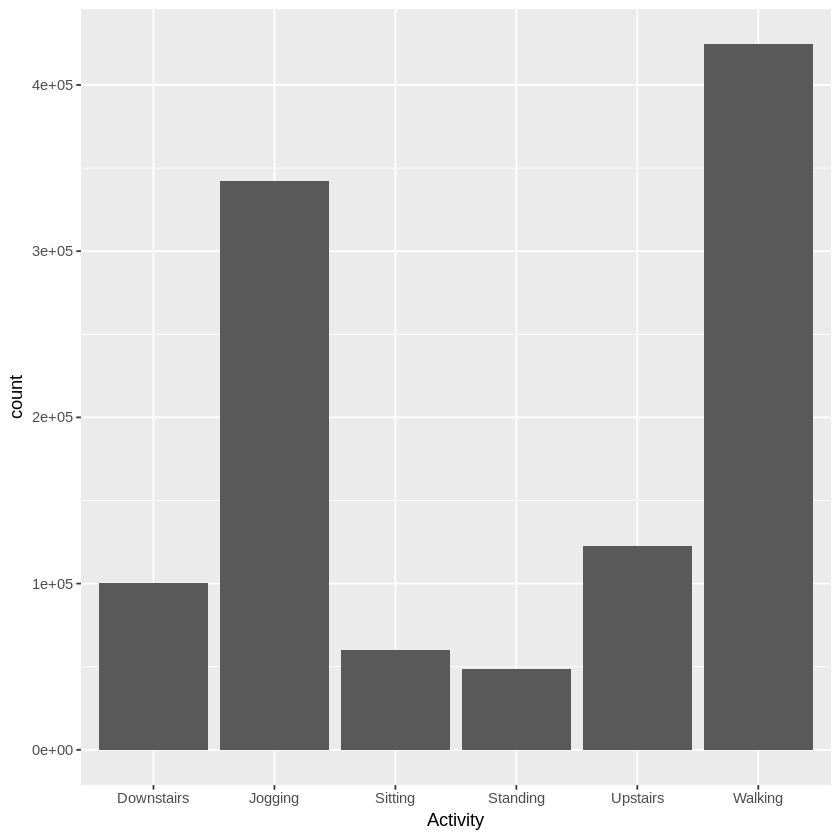

In [5]:
library(ggplot2)
ggplot(data, aes(x=Activity)) +
  geom_bar()

Let us also plot the number of examples we have for each user.

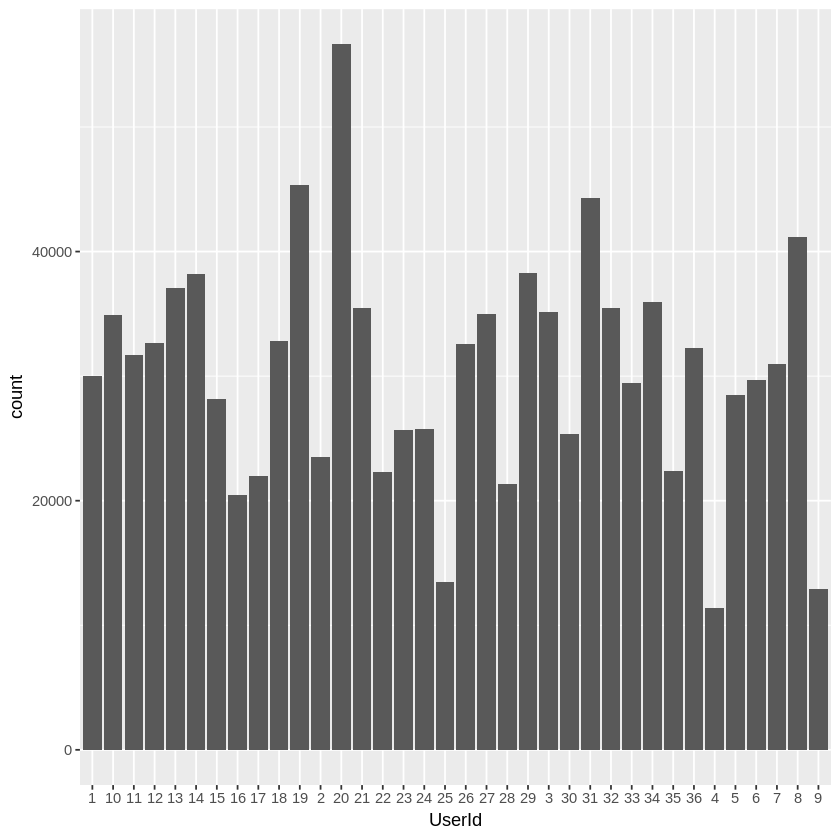

In [6]:
library(ggplot2)
ggplot(data, aes(x=UserId)) +
  geom_bar()

## 1.3 Dataset splitting
We want to create a neural network model which can correctly recognise the activity of a new user. We will therefore evaluate the model on users we do not train on. We will therefore need to sample users to use for our training, validation and test sets.

We will do this manually and check the class distribution in of each dataset.

[1] 0.1745379

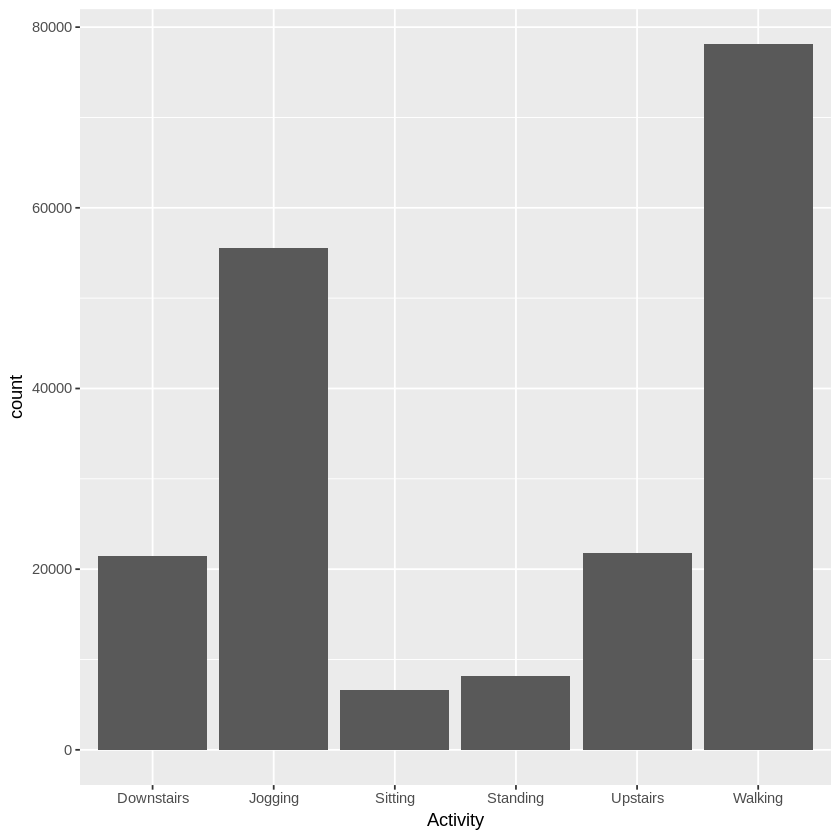

In [7]:
# We select users from 24 up to and including 30 to be in our validation data.
val_idx <- data['UserId'] == '24' |
             data['UserId'] == '25' |
             data['UserId'] == '26' |
             data['UserId'] == '27' |
             data['UserId'] == '28' |
             data['UserId'] == '29' |
             data['UserId'] == '30'
val_data <- data[val_idx, ]
# The fraction of the total data
nrow(val_data)/nrow(data)
ggplot(val_data, aes(x=Activity)) +
  geom_bar()

The distribution is not exactly the same as we saw over the whole data. We seem to be lacking some "Sitting" examples.

Now for the test dataset.

[1] 0.1819727

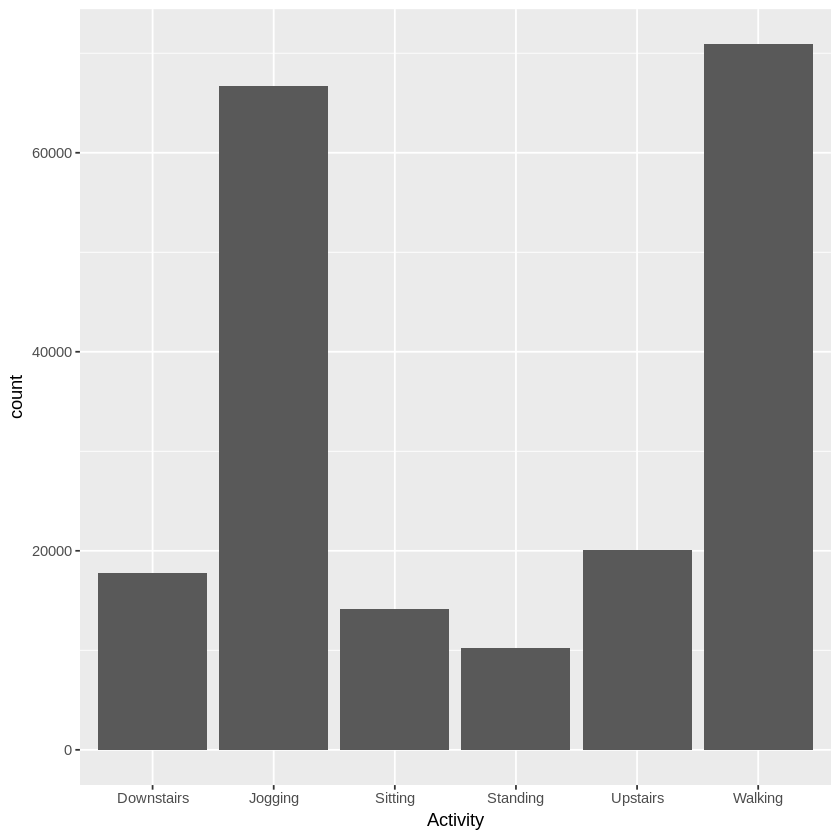

In [8]:
test_idx <- data['UserId'] == '31' |
              data['UserId'] == '32' |
              data['UserId'] == '33' |
              data['UserId'] == '34' |
              data['UserId'] == '35' |
              data['UserId'] == '36'
test_data <- data[test_idx, ]
nrow(test_data)/nrow(data)
ggplot(test_data, aes(x=Activity)) +
  geom_bar()

Our test dataset seems to have a similar distribution as our whole dataset, and in the cell below we will see that our training set is very similar to our test set. We thus expect our model to generalise well from the training data to the test data and we expect to perform better on the test set rather than the validation set. This means that our validation dataset will be harder than the test dataset. Keep this in mind when training and evaluating your model.

Our training dataset will be the remaining rows:

[1] 0.6434894

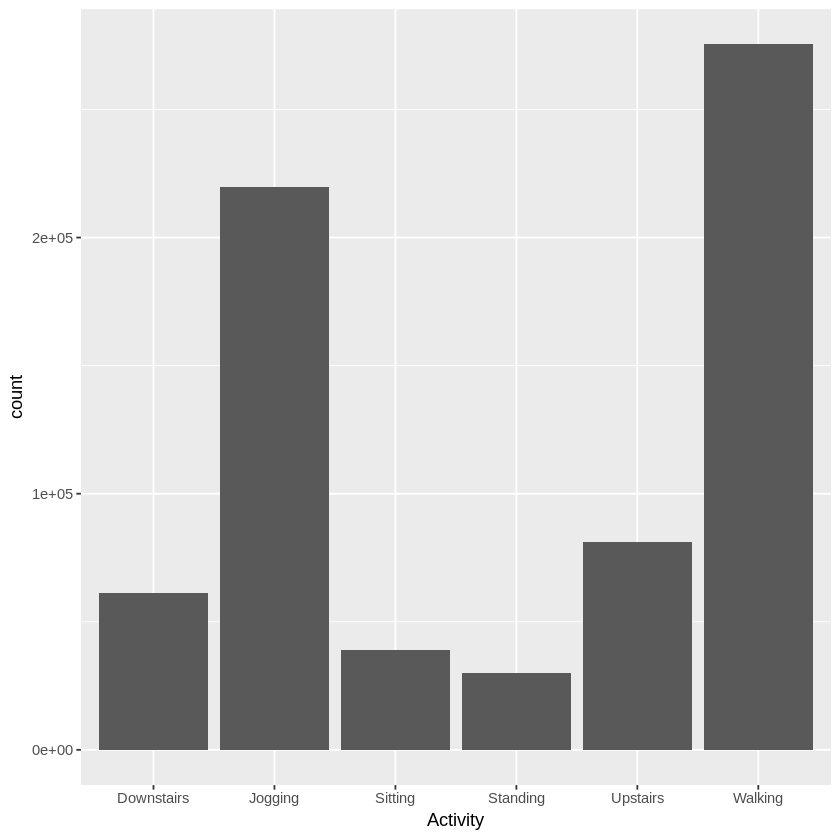

In [9]:
# we select all entities in the validation set and the test set, and take the compliment.
train_idx <- !(val_idx | test_idx)
train_data <- data[train_idx, ]
nrow(train_data)/nrow(data)
ggplot(train_data, aes(x=Activity)) +
  geom_bar()

Now we drop the `UserId` column as we will not use it to make predictions.

In [10]:
train_data <- train_data[, -(1)]
val_data <- val_data[, -(1)]
test_data <- test_data[, -(1)]
dim(train_data)
dim(val_data)
dim(test_data)

[1] 706682      4

[1] 191678      4

[1] 199843      4

## 1.4 Creating sequences
Now we want to create the sequences which we will use to train and evaluate our model. Our sequences will be 5 seconds long, that is, a sequence length of 100. We use the label of the last element in the sequence as a target, `target_shift = -1`. Since our dataset is quite large we get plenty of examples, so we shift 50 steps for each sequence to keep the number of sequences in an acceptable range (this sequence length and shift was set after some experimentation). Feel free to adjust these values if you feel like.

In [11]:
train_seq <- create_sequences_x_y(data = train_data, sequence_length = 100, target_shift = -1, step_shift = 50)
dim(train_seq$x)
dim(train_seq$y)
val_seq <- create_sequences_x_y(data = val_data, sequence_length = 100, target_shift = -1, step_shift = 50)
dim(val_seq$x)
dim(val_seq$y)
test_seq <- create_sequences_x_y(data = test_data, sequence_length = 100, target_shift = -1, step_shift = 50)
dim(test_seq$x)
dim(test_seq$y)

[1] 14132   100     4

[1] 14132     4

[1] 3832  100    4

[1] 3832    4

[1] 3995  100    4

[1] 3995    4

A minor note: When creating the sequences we created some sequences which contain data from two different UserIds, which will never happen in real-life. We do not care that much about this defect in our data processing, since the number of sequences which are from two different UserIds are **very** few (at most 36*2 out of 14132+3832+3995).

Now we drop last few columns which we do not need. We drop the label from the input sequences and drop the accelormeter data from the targets.

In [12]:
# Keep drop labels for the input features, x
train_seq$x <- train_seq$x[ , , -1]
# Keep the labels for the y data.
train_seq$y <- train_seq$y[ , 1]
head(train_seq$x)
head(train_seq$y)

[1] "  0.57205460" "  2.36994050" "  1.68892310" "  1.03514650" " -0.53119355"
[6] "  5.01228800"

[1] "Walking" "Walking" "Walking" "Walking" "Walking" "Walking"

We do the same for the validation and test data.

In [13]:
val_seq$x <- val_seq$x[ , , -1]
val_seq$y <- val_seq$y[ , 1]
test_seq$x <- test_seq$x[ , , -1]
test_seq$y <- test_seq$y[ , 1]

## 1.5 Scaling
To help our network train faster, we need to **scale** our data. In this assignment we will scale our data using the Min/Max approach, the same approach as we did for for the last assignment.

We will scale the data so that the largest value in our training data will have value `1` and the smallest value will have the value `0`. To achieve this we do:

$$
x' = \frac{x - \min(\boldsymbol{x})}{\max(\boldsymbol{x}) - \min(\boldsymbol{x})}
$$

Where $x$ is a single example and $x'$ is our new scaled value. $\min(\boldsymbol{x})$ is the smallest value in the training set and $\max(\boldsymbol{x})$ is the largest value.
For the interested we recommend the [wikipedia article](https://en.wikipedia.org/wiki/Feature_scaling).

In [14]:
# We initialise our arrays in the shape we want them to be.
x_train_scaled <- array(0, dim = dim(train_seq$x))
x_val_scaled <- array(0, dim = dim(val_seq$x))
x_test_scaled <- array(0, dim = dim(test_seq$x))
dim(x_train_scaled)
dim(x_val_scaled)
dim(x_test_scaled)


for (j in 1:dim(train_seq$x)[3]) {
    # For each feature we compute the max and scale
    min_train <- min(as.numeric(train_seq$x[,,j]))
    max_train <- max(as.numeric(train_seq$x[,,j]))
    
    # For each dataset and feature we scale the values according to the max/min
    x_train_scaled[,,j] <- (as.numeric(train_seq$x[,,j]) - min_train) / (max_train - min_train)
    x_val_scaled[,,j] <- (as.numeric(val_seq$x[,,j]) - min_train) / (max_train - min_train)
    x_test_scaled[,,j] <- (as.numeric(test_seq$x[,,j]) - min_train) / (max_train - min_train)
}
min(x_train_scaled)
max(x_train_scaled)

[1] 14132   100     3

[1] 3832  100    3

[1] 3995  100    3

[1] 0

[1] 1

We also need to map our labels to the one-hot encoding representation, as a first step we need to map the text to a numerical value and then we use the `to_categorical` function from Keras. The `category_to_label` function below maps the text to a numerical value which the `to_categorical` function can translate.

In [15]:
category_to_label <- function(category) {
    if (category == "Downstairs")
        0
    else if (category == "Jogging")
        1
    else if (category == "Sitting")
        2
    else if (category == "Standing")
        3
    else if (category == "Upstairs")
        4
    else if (category == "Walking")
        5
    else
        -1
}

In [16]:
y_train <- to_categorical(lapply(train_seq$y, FUN = category_to_label))
y_val <- to_categorical(lapply(val_seq$y, FUN = category_to_label))
y_test <- to_categorical(lapply(test_seq$y, FUN = category_to_label))

## 2. The model
In this section you will implement the model. You need to construct a model which assigns one of 6 classes to each sequence.

To achieve a score of `1` for the assignment you only need to implement the baseline model and achieve accuracy higher than 80% on the **test set**. To achieve a score of `2` for the assignment you will need to achieve accuracy higher than 90% on the **test set**. Keep in mind that the test set is easier than the validation set.

We leave the model definition completely up to you but suggest that you start by trying some of the layers below.
- `layer_dense`
- `layer_conv_1d`
- `layer_gru`

**Answer**: this is just an example model. You can try different models. We have found stacked GRUs to work quite well. In our experiments we found convolutional or dense models without any recurrent components quite tricky to converge reliably. Regularisation may help a bit there, but be aware that you will need spatial dropout after a convolutional layer rather than ordinary dropout.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru (GRU)                           (None, 100, 16)                 960         
________________________________________________________________________________
gru_1 (GRU)                         (None, 16)                      1584        
________________________________________________________________________________
dense (Dense)                       (None, 6)                       102         
Total params: 2,646
Trainable params: 2,646
Non-trainable params: 0
________________________________________________________________________________


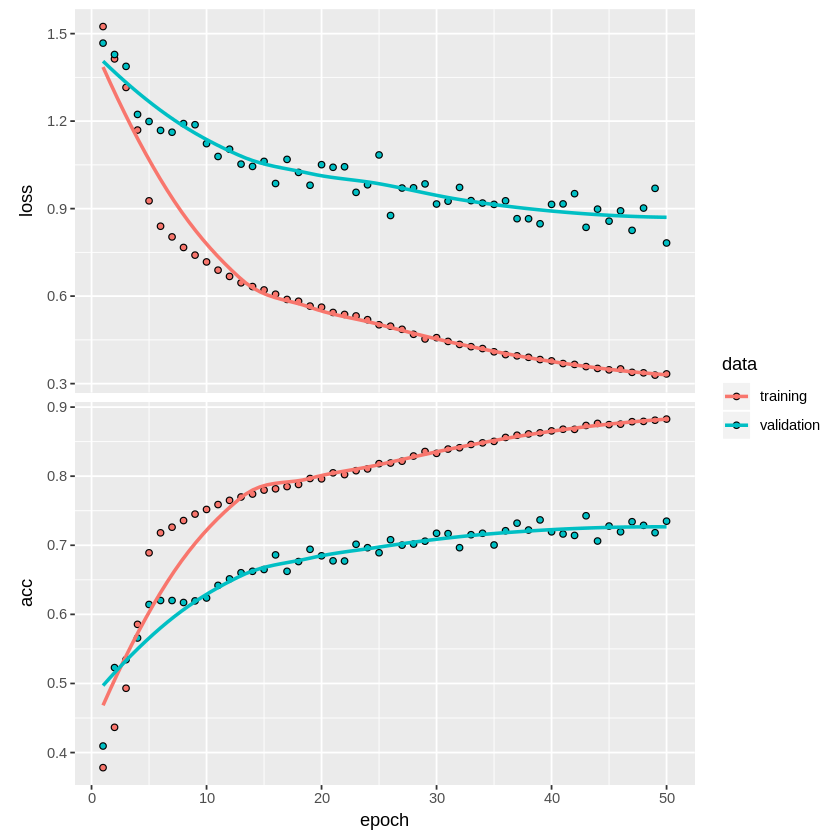

In [17]:
model <- keras_model_sequential() %>%
    layer_gru(units = 16, input_shape = c(100, 3), return_sequences = TRUE, recurrent_dropout = 0.2) %>%
    layer_gru(units = 16, input_shape = c(100, 3), recurrent_dropout = 0.2, dropout = 0.2) %>%
    layer_dense(units = 6, activation = 'softmax')

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "categorical_crossentropy",
    metrics = c('acc')
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_data = list(x_val_scaled, y_val),
    epochs = 50,
    batch_size = 64,
    callbacks=list(Progress$new())
)

plot(history)

When you finished tuning your model evaluate your model and report the loss over the test set. Methodologically, you should only evaluate your once (or not very often). Try to keep to that convention.

## 5.2 Evaluate the model
Evaluate your model and report the loss over the test dataset.

In [18]:
model %>% evaluate(x_test_scaled, y_test)

$loss
[1] 0.4123243

$acc
[1] 0.8723404

## Improving the model
There are various ways of improving the model: increasing the model complexity, changing the model architecture, and preprocessing the data differently.

Increasing the size of the data set is one of the most effective ways of improving the performance of a deep learning model. The cell below increases the data size five-fold (using the `step_shift` parameter) while reducing the sequence length, and evaluates the performance of a stacked GRU that has been regularised quite heavily.

An even more effective, and also cleaner way of preprocessing the data would be to sample sequences per individual. In that way we prevent sequences from having data for two individuals caused by sampling across individual's data boundaries.

We have found that it is quite tricky to train a model without recurrent components to have a performance higher than 0.90. It is certainly possible, but stability may be an issue. It also appears that preprocessing the data with convolutional layers before sending it to a GRU or LSTM has generally very little effect: a stacked GRU is usually just as effective.

In [19]:
data <- load_activity_dataset()
data <- data[, -(3)]
data <- data[seq(1, nrow(data), 2), ]
val_idx <- data['UserId'] == '24' |
             data['UserId'] == '25' |
             data['UserId'] == '26' |
             data['UserId'] == '27' |
             data['UserId'] == '28' |
             data['UserId'] == '29' |
             data['UserId'] == '30'
val_data <- data[val_idx, ]
test_idx <- data['UserId'] == '31' |
              data['UserId'] == '32' |
              data['UserId'] == '33' |
              data['UserId'] == '34' |
              data['UserId'] == '35' |
              data['UserId'] == '36'
test_data <- data[test_idx, ]
# we select all entities in the validation set and the test set, and take the compliment.
train_idx <- !(val_idx | test_idx)
train_data <- data[train_idx, ]
train_data <- train_data[, -(1)]
val_data <- val_data[, -(1)]
test_data <- test_data[, -(1)]
train_seq <- create_sequences_x_y(data = train_data, sequence_length = 50, target_shift = -1, step_shift = 5)

val_seq <- create_sequences_x_y(data = val_data, sequence_length = 50, target_shift = -1, step_shift = 5)

test_seq <- create_sequences_x_y(data = test_data, sequence_length = 50, target_shift = -1, step_shift = 5)

# Keep everything but the labels
train_seq$x <- train_seq$x[ , , -1]
# Keep the labels for the y data.
train_seq$y <- train_seq$y[ , 1]

val_seq$x <- val_seq$x[ , , -1]
val_seq$y <- val_seq$y[ , 1]
test_seq$x <- test_seq$x[ , , -1]
test_seq$y <- test_seq$y[ , 1]
x_train_scaled <- array(0, dim = dim(train_seq$x))
x_val_scaled <- array(0, dim = dim(val_seq$x))
x_test_scaled <- array(0, dim = dim(test_seq$x))

dim(x_train_scaled)

# For each feature we compute the max and scale
for (j in 1:dim(train_seq$x)[3]) {
    min_train <- min(as.numeric(train_seq$x[,,j]))
    max_train <- max(as.numeric(train_seq$x[,,j]))
    x_train_scaled[,,j] <- (as.numeric(train_seq$x[,,j]) - min_train) / (max_train - min_train)
    x_val_scaled[,,j] <- (as.numeric(val_seq$x[,,j]) - min_train) / (max_train - min_train)
    x_test_scaled[,,j] <- (as.numeric(test_seq$x[,,j]) - min_train) / (max_train - min_train)
}

y_train <- to_categorical(lapply(train_seq$y, FUN = category_to_label))
y_val <- to_categorical(lapply(val_seq$y, FUN = category_to_label))
y_test <- to_categorical(lapply(test_seq$y, FUN = category_to_label))

[1] 70658    50     3

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_2 (GRU)                         (None, 50, 32)                  3456        
________________________________________________________________________________
gru_3 (GRU)                         (None, 50, 32)                  6240        
________________________________________________________________________________
gru_4 (GRU)                         (None, 32)                      6240        
________________________________________________________________________________
dense_1 (Dense)                     (None, 6)                       198         
Total params: 16,134
Trainable params: 16,134
Non-trainable params: 0
________________________________________________________________________________


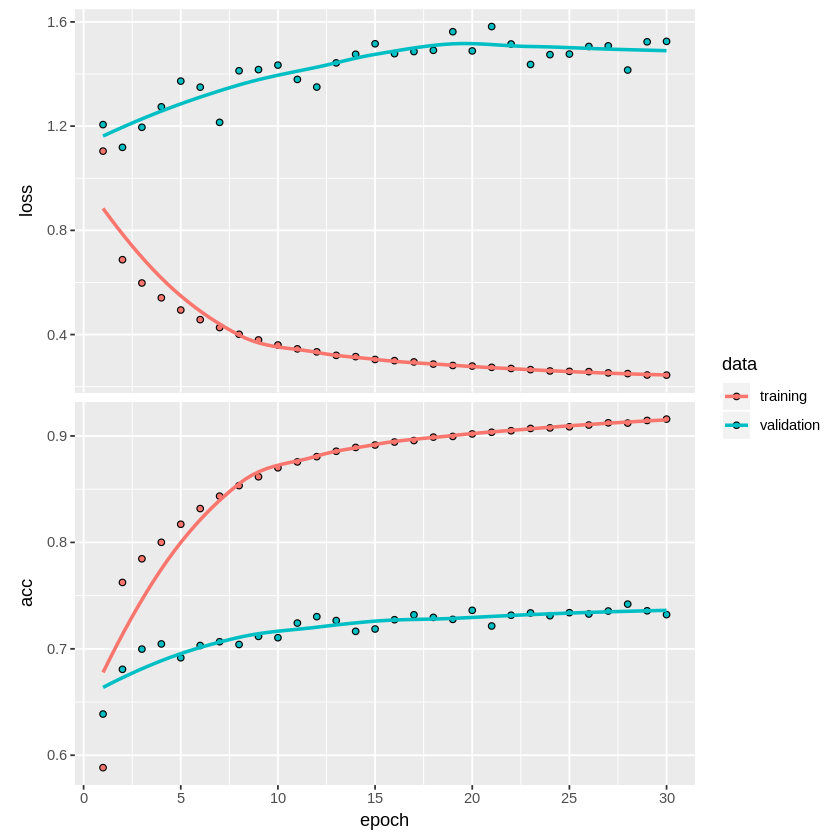

In [20]:
model <- keras_model_sequential() %>%
    layer_gru(units = 32, input_shape = c(50, 3), return_sequences = TRUE, recurrent_dropout = 0.5) %>%
    layer_gru(units = 32, input_shape = c(50, 3), return_sequences = TRUE, recurrent_dropout = 0.5, dropout = 0.5) %>%
    layer_gru(units = 32, input_shape = c(50, 3), recurrent_dropout = 0.75, dropout = 0.5) %>%
    layer_dense(units = 6, activation = 'softmax')

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "categorical_crossentropy",
    metrics = c('acc')
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_data = list(x_val_scaled, y_val),
    epochs = 30,
    batch_size = 32,
    callbacks=list(Progress$new())
)

plot(history)

In [21]:
model %>% evaluate(x_test_scaled, y_test)

$loss
[1] 0.2594052

$acc
[1] 0.9330663